In [25]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,adjusted_rand_score,normalized_mutual_info_score,accuracy_score
from scipy.optimize import linear_sum_assignment


In [5]:
digits = load_digits()
x=digits.data
y=digits.target
images = digits.images
class_names = digits.target_names
n_samples , n_features = x.shape
n_classes = len(np.unique(y))
print("=== Digits Dataset Info ===")
print(f"Number of samples (n_samples): {n_samples}")
print(f"Number of features: {n_features} (each image is 8x8 => 64 features)")
print(f"Number of classes (n_classes): {n_classes}")
print(f"Class labels: {class_names}")

x_scaled=StandardScaler().fit_transform(x)



=== Digits Dataset Info ===
Number of samples (n_samples): 1797
Number of features: 64 (each image is 8x8 => 64 features)
Number of classes (n_classes): 10
Class labels: [0 1 2 3 4 5 6 7 8 9]


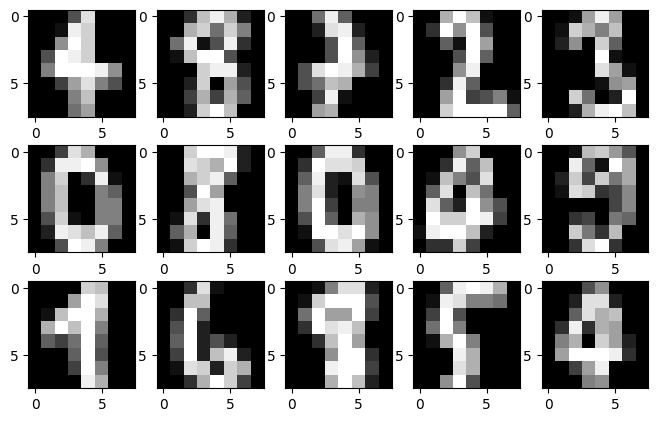

In [6]:
fig, axes = plt.subplots(3, 5, figsize=(8, 5))
idx = np.random.choice(len(digits.images), 15, replace=False)

for ax, i in zip(axes.flat, idx):
    ax.imshow(digits.images[i], cmap='gray')

In [7]:
K_values = range(6, 15)
inertias = []
silhouette_scores = []

for K in K_values:
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
    kmeans.fit(x_scaled)

    # WCSS
    inertias.append(kmeans.inertia_)

    # Silhouette Score
    score = silhouette_score(x_scaled, kmeans.labels_)
    silhouette_scores.append(score)



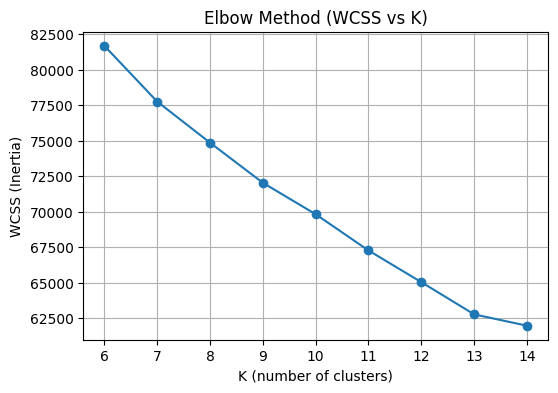

In [8]:
plt.figure(figsize=(6, 4))
plt.plot(K_values, inertias, marker='o')
plt.xlabel("K (number of clusters)")
plt.ylabel("WCSS (Inertia)")
plt.title("Elbow Method (WCSS vs K)")
plt.grid(True)
plt.show()


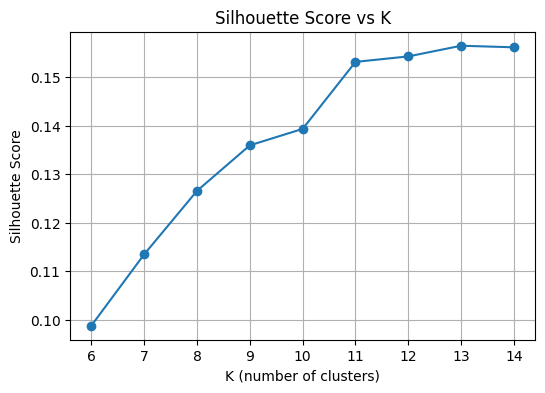

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(K_values, silhouette_scores, marker='o')
plt.xlabel("K (number of clusters)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs K")
plt.grid(True)
plt.show()


In [10]:
K = 10
inertias = []
labels_list = []
seeds = [0, 1, 2, 3, 4]
for seed in seeds:
    kmeans = KMeans(
        n_clusters=10,
        init="k-means++",
        n_init=1,          # فقط یک initialization
        random_state=seed
    )
    kmeans.fit(x_scaled)

    inertias.append(kmeans.inertia_)
    labels_list.append(kmeans.labels_)

for seed, inertia in zip(seeds, inertias):
    print(f"random_state={seed} -> inertia={inertia:.2f}")

random_state=0 -> inertia=69749.08
random_state=1 -> inertia=70785.03
random_state=2 -> inertia=69416.84
random_state=3 -> inertia=71714.53
random_state=4 -> inertia=71687.13


In [11]:
print("\nAdjusted Rand Index between different runs:")

for i in range(len(labels_list)):
    for j in range(i+1, len(labels_list)):
        ari = adjusted_rand_score(labels_list[i], labels_list[j])
        print(f"Run {i} vs Run {j}: ARI = {ari:.3f}")



Adjusted Rand Index between different runs:
Run 0 vs Run 1: ARI = 0.776
Run 0 vs Run 2: ARI = 0.749
Run 0 vs Run 3: ARI = 0.677
Run 0 vs Run 4: ARI = 0.669
Run 1 vs Run 2: ARI = 0.798
Run 1 vs Run 3: ARI = 0.595
Run 1 vs Run 4: ARI = 0.740
Run 2 vs Run 3: ARI = 0.568
Run 2 vs Run 4: ARI = 0.665
Run 3 vs Run 4: ARI = 0.553


In [12]:
inertias_random = []

for i in range(5):
    kmeans = KMeans(
        n_clusters=10,
        init="random",
        n_init=1
    )
    kmeans.fit(x_scaled)
    inertias_random.append(kmeans.inertia_)

print("\nInertia with random initialization:")
for i, val in enumerate(inertias_random):
    print(f"Run {i}: inertia = {val:.2f}")



Inertia with random initialization:
Run 0: inertia = 71893.98
Run 1: inertia = 70555.73
Run 2: inertia = 69706.44
Run 3: inertia = 70886.66
Run 4: inertia = 71611.27


In [13]:
# فرض: همین kmeans آخر (با K=10) رو داری و fit شده
y_pred = kmeans.labels_
y_true = y

# 1) ARI و NMI (نیازی به Hungarian ندارند)
ari = adjusted_rand_score(y_true, y_pred)
nmi = normalized_mutual_info_score(y_true, y_pred)
print(f"ARI = {ari:.4f}")
print(f"NMI = {nmi:.4f}")

# 2) Hungarian mapping برای Accuracy
D = max(y_pred.max(), y_true.max()) + 1
conf_mat = np.zeros((D, D), dtype=np.int64)
for i in range(len(y_true)):
    conf_mat[y_pred[i], y_true[i]] += 1

row_ind, col_ind = linear_sum_assignment(conf_mat.max() - conf_mat)
mapping = {row: col for row, col in zip(row_ind, col_ind)}

y_pred_mapped = np.array([mapping[c] for c in y_pred])
acc = accuracy_score(y_true, y_pred_mapped)
print(f"Accuracy (after Hungarian mapping) = {acc:.4f}")

ARI = 0.5032
NMI = 0.6639
Accuracy (after Hungarian mapping) = 0.6127


نقاط قوت K-Means در این مسئله

سادگی و سرعت بالا:
K-Means الگوریتمی سریع و مقیاس‌پذیر است و روی دیتاست Digits با 1797 نمونه و 64 ویژگی به‌راحتی اجرا می‌شود.

کشف ساختار کلی داده بدون برچسب:
با انتخاب
𝐾
≈
10
K≈10، الگوریتم می‌تواند تا حدی ساختار طبیعی ارقام را شناسایی کند و خوشه‌هایی بسازد که غالباً متناظر با ارقام واقعی هستند.

عملکرد عددی قابل قبول:
مقادیری مانند ARI و NMI نشان می‌دهند که علی‌رغم بدون‌ناظر بودن، خوشه‌بندی به‌طور معنی‌داری بهتر از حالت تصادفی است.

قابل تفسیر بودن مراکز خوشه‌ها:
مراکز خوشه‌ها را می‌توان به‌صورت تصاویر ۸×۸ نمایش داد که شبیه «رقم میانگین» هر خوشه هستند.

محدودیت‌ها و ضعف‌های K-Means

فرض خوشه‌های کروی و فاصله‌ی اقلیدسی:
K-Means فرض می‌کند خوشه‌ها کروی و از نظر واریانس مشابه‌اند، در حالی که شکل واقعی داده‌های تصویری پیچیده‌تر است.

حساسیت به initialization و مینیمم‌های محلی:
نتایج الگوریتم بسته به مقداردهی اولیه می‌تواند متفاوت باشد و به مینیمم‌های محلی مختلف همگرا شود.

بی‌توجهی به ساختار فضایی تصویر:
هر تصویر فقط به‌صورت یک بردار ۶۴بعدی در نظر گرفته می‌شود و ارتباط مکانی پیکسل‌ها (مثلاً خطوط و منحنی‌ها) نادیده گرفته می‌شود.

تداخل خوشه‌ها به‌دلیل شباهت ظاهری ارقام

برخی ارقام در دیتاست Digits از نظر شکل نوشتاری و شدت پیکسل‌ها شباهت زیادی دارند، برای مثال:

1 و 7

3 و 8

4 و 9

0 و 6

این شباهت‌ها باعث می‌شود:

فاصله‌ی اقلیدسی بین تصاویر این ارقام کوچک باشد

نمونه‌های مربوط به این ارقام در فضای ویژگی‌ها روی هم بیفتند

حتی با انتخاب
𝐾
=
10
K=10، بعضی خوشه‌ها شامل ترکیبی از چند رقم شوند

در نتیجه:

حتی اگر معیارهای عددی مانند ARI، NMI یا Accuracy نسبتاً خوب باشند،
مرز بین خوشه‌ها لزوماً منطبق بر مرزهای معنایی ارقام نیست.

جمع‌بندی نهایی)

K-Means می‌تواند ساختار کلی دیتاست Digits را تا حدی کشف کند و خوشه‌بندی معناداری ارائه دهد، اما به‌دلیل فرض‌های ساده‌کننده، حساسیت به فاصله‌ی اقلیدسی و شباهت ذاتی برخی ارقام، قادر به تفکیک کامل کلاس‌ها نیست. این مسئله نشان می‌دهد که برای داده‌های تصویری، روش‌هایی که از ساختار مکانی و ویژگی‌های پیچیده‌تر استفاده می‌کنند (مانند PCA+KMeans، GMM یا مدل‌های یادگیری عمیق) می‌توانند عملکرد بهتری داشته باشند.

question 2

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


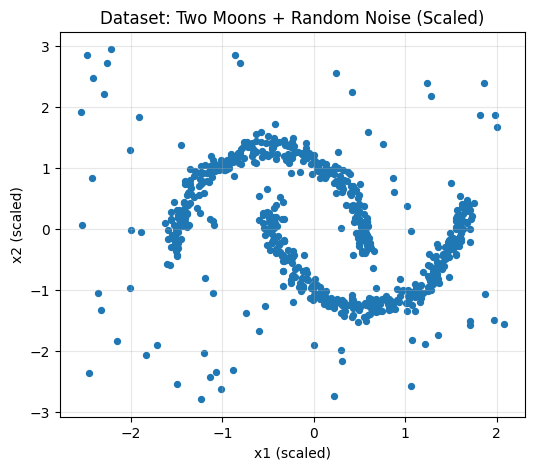

In [22]:
X, y_true = make_moons(n_samples=600, noise=0.06, random_state=42)


rng = np.random.RandomState(42)
n_noise = 80
noise = rng.uniform(low=[-2.0, -1.5], high=[2.5, 2.0], size=(n_noise, 2))

X_all = np.vstack([X, noise])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)


plt.figure(figsize=(6,5))
plt.scatter(X_scaled[:,0], X_scaled[:,1], s=18)
plt.title("Dataset: Two Moons + Random Noise (Scaled)")
plt.xlabel("x1 (scaled)")
plt.ylabel("x2 (scaled)")
plt.grid(True, alpha=0.3)
plt.show()


eps=0.15, min_samples=5 -> clusters=2, noise_points=77


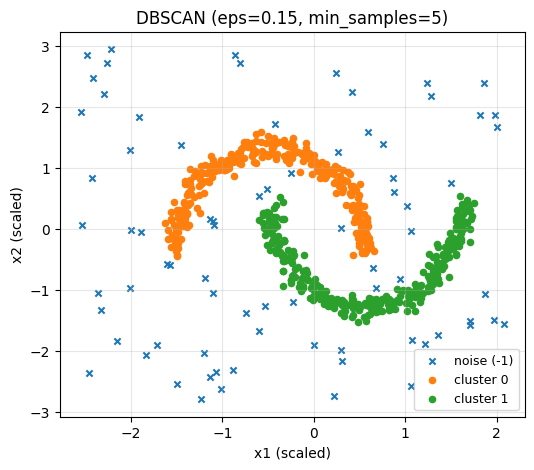

eps=0.2, min_samples=5 -> clusters=2, noise_points=67


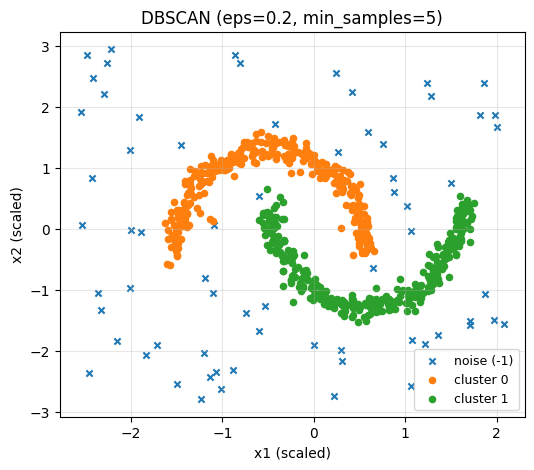

eps=0.25, min_samples=5 -> clusters=2, noise_points=62


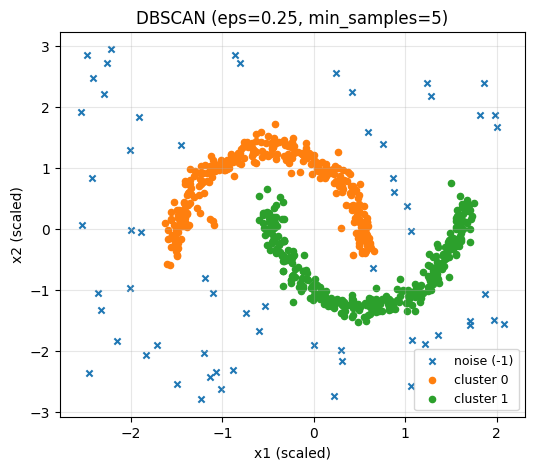

eps=0.15, min_samples=10 -> clusters=2, noise_points=81


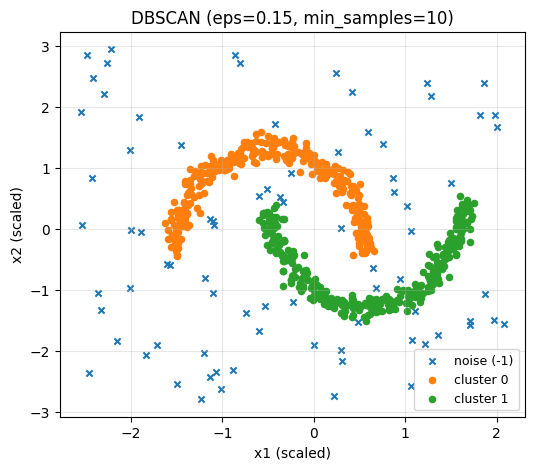

eps=0.2, min_samples=10 -> clusters=2, noise_points=70


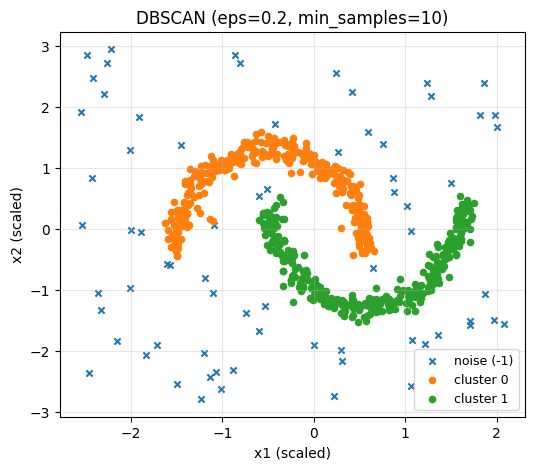

eps=0.25, min_samples=10 -> clusters=2, noise_points=64


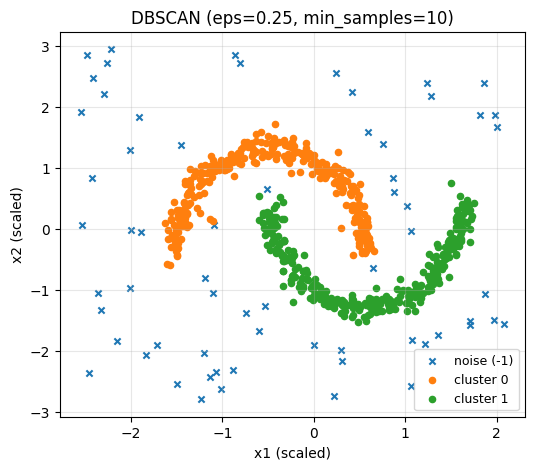

In [23]:
def plot_dbscan_result(X, labels, title):
    plt.figure(figsize=(6,5))
    unique = np.unique(labels)
    for lab in unique:
        mask = labels == lab
        if lab == -1:
            plt.scatter(X[mask,0], X[mask,1], s=20, marker='x', label='noise (-1)')
        else:
            plt.scatter(X[mask,0], X[mask,1], s=20, label=f'cluster {lab}')
    plt.title(title)
    plt.xlabel("x1 (scaled)")
    plt.ylabel("x2 (scaled)")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="best", fontsize=9)
    plt.show()

param_list = [
    (0.15, 5),
    (0.20, 5),
    (0.25, 5),
    (0.15, 10),
    (0.20, 10),
    (0.25, 10),
]

for eps, ms in param_list:
    db = DBSCAN(eps=eps, min_samples=ms)
    labels = db.fit_predict(X_scaled)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)

    print(f"eps={eps}, min_samples={ms} -> clusters={n_clusters}, noise_points={n_noise}")
    plot_dbscan_result(X_scaled, labels, f"DBSCAN (eps={eps}, min_samples={ms})")

1) eps خیلی کوچک → «بیش‌نویز» و گاهی «بیش‌خوشه‌بندی»

همسایگی کوچک است، خیلی از نقاط “هسته” نمی‌شوند

نتیجه: تعداد نویز زیاد، خوشه‌ها تکه‌تکه می‌شوند

2) eps خیلی بزرگ → «کم‌خوشه‌بندی» (ادغام خوشه‌ها)

همسایگی بزرگ باعث اتصال دو هلال یا اتصال نویزها به خوشه‌ها می‌شود

نتیجه: خوشه‌ها یکی می‌شوند، نویز کمتر دیده می‌شود (گاهی نویز هم جذب خوشه می‌شود)

3) min_samples بزرگ‌تر → سخت‌گیری بیشتر

برای هسته شدن، تعداد همسایه بیشتری لازم است

نتیجه:

نقاط مرزی راحت‌تر نویز می‌شوند

خوشه‌ها محافظه‌کارانه‌تر ساخته می‌شوند

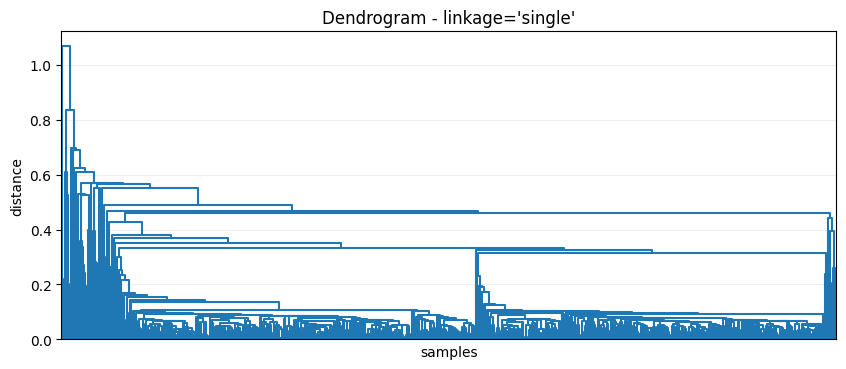

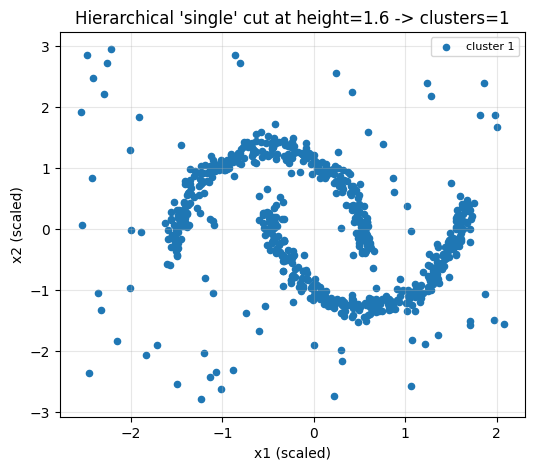

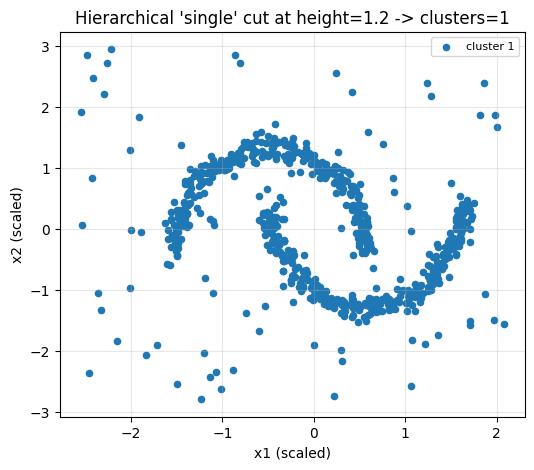

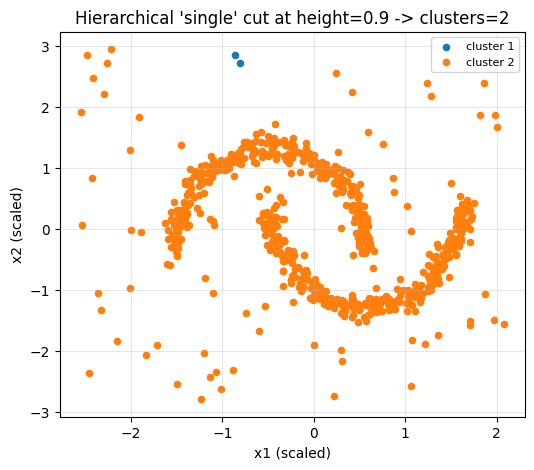

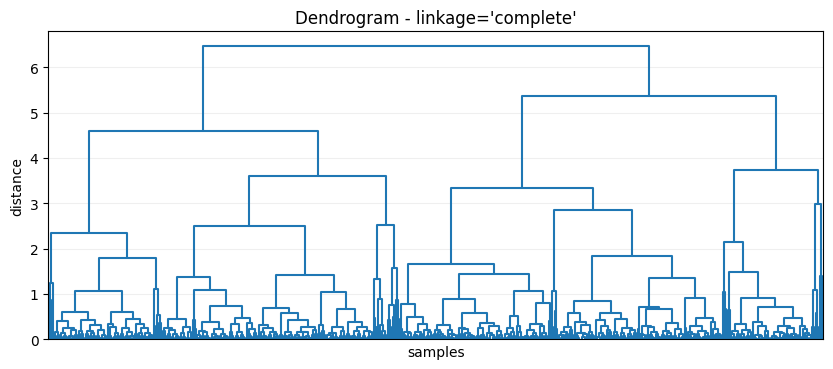

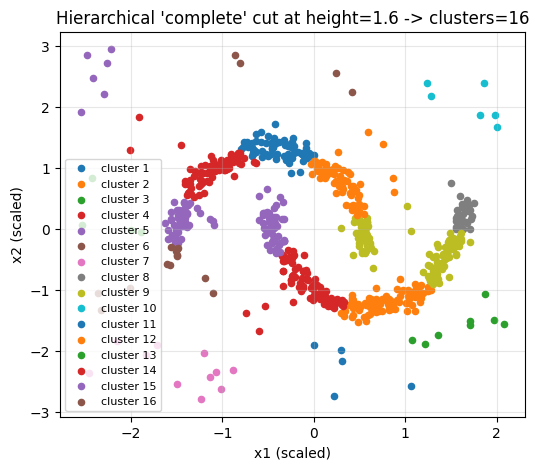

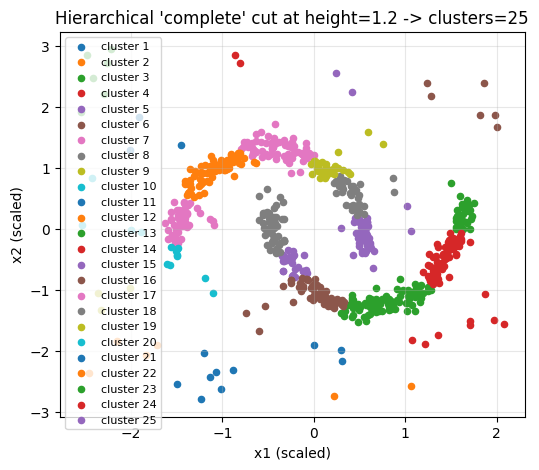

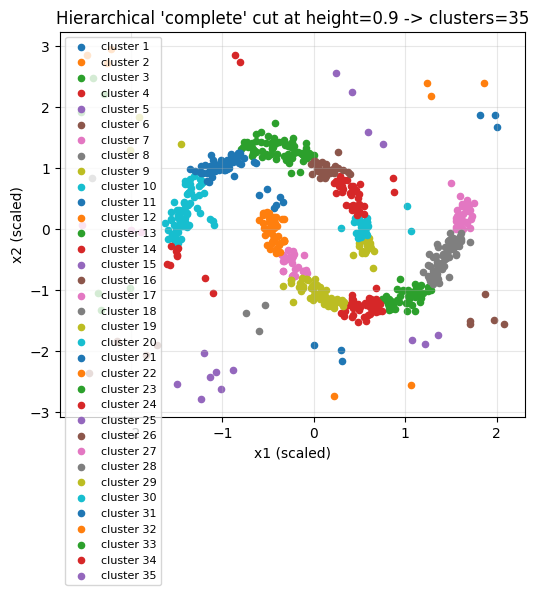

In [24]:
def run_hierarchical_and_plot(X, method, cut_heights):

    Z = linkage(X, method=method, metric='euclidean')


    plt.figure(figsize=(10,4))
    dendrogram(Z, no_labels=True, color_threshold=0)
    plt.title(f"Dendrogram - linkage='{method}'")
    plt.xlabel("samples")
    plt.ylabel("distance")
    plt.grid(True, alpha=0.2)
    plt.show()

    for h in cut_heights:
        labels = fcluster(Z, t=h, criterion='distance')
        n_clusters = len(np.unique(labels))
        plt.figure(figsize=(6,5))
        for lab in np.unique(labels):
            mask = labels == lab
            plt.scatter(X[mask,0], X[mask,1], s=20, label=f'cluster {lab}')
        plt.title(f"Hierarchical '{method}' cut at height={h} -> clusters={n_clusters}")
        plt.xlabel("x1 (scaled)")
        plt.ylabel("x2 (scaled)")
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=8, loc="best")
        plt.show()

run_hierarchical_and_plot(X_scaled, method="single",   cut_heights=[1.2, 0.9, 0.7])
run_hierarchical_and_plot(X_scaled, method="complete", cut_heights=[1.6, 1.2, 0.9])
#[1.2, 0.9, 0.7]

د) نتایج  DBSCANو  Hierarchical Clusteringرا از دو جنبهی زیر با هم مقایسه کنید
1) توانایی شناسایی شکل‌های غیرکروی (هلالی)
DBSCAN

✅ معمولاً عالی است چون:

بر اساس چگالی است نه “مرکز خوشه”

می‌تواند خوشه‌های خمیده/مارپیچی را پیدا کند (اگر eps و min_samples درست باشند)

Hierarchical

single linkage گاهی می‌تواند شکل غیرکروی را دنبال کند ✅
اما مشکل بزرگش:

اثر زنجیره‌ای: با چند نقطه‌ی نویزی که بین دو خوشه افتاده باشند، دو خوشه را به هم وصل می‌کند ❌

complete/average خوشه‌ها را فشرده‌تر می‌خواهد → برای هلال‌ها ممکن است “بد” باشد و خوشه را تکه‌تکه کند یا مرزها را غلط ببندد.

2) توانایی شناسایی نویز
DBSCAN

✅ ذاتاً نویز را با برچسب -1 مشخص می‌کند
این یکی از بزرگ‌ترین مزیت‌های DBSCAN است.

Hierarchical

❌ نویز را به عنوان یک مفهوم رسمی ندارد
نویز یا:

به نزدیک‌ترین خوشه می‌چسبد

یا باعث اتصال خوشه‌ها می‌شود (به‌خصوص در single)

فرض‌های بنیادی و علت تفاوت خروجی

DBSCAN فرض می‌کند: خوشه = ناحیه‌ی با چگالی بالا و جدایی با نواحی کم‌چگالی.

Hierarchical فرض می‌کند: ساختار خوشه‌ها از ادغام مرحله‌ای فاصله‌ها در می‌آید؛ به نویز حساس است چون هر نقطه باید جایی در درخت ادغام شود.

همین تفاوت نگاه (چگالی vs فاصله/ادغام) باعث تفاوت محسوس روی داده‌ی هلالیِ نویزی می‌شود.

هـ) در پایان، یک سناریوی واقعی (مثلاً در حوزهی تشخیص الگو، سامانههای فضایی، دادههای سنسوری یا شبکههای اجتماعی)
پیشنهاد کنید که در آن ترجیح دهید از  DBSCANاستفاده کنید و یک سناریوی دیگر که در آن Hierarchical Clustering
مناسبتر است. برای هر سناریو کوتاه توضیح دهید ساختار داده و نیاز مسئله چگونه با نقاط قوت آن الگوریتم همخوانی دارد.
سناریویی که DBSCAN را ترجیح می‌دهم
مثال: داده‌های GPS / سنسوری / نقاط مکانی با نویز

مثل تحلیل “مکان‌های پرتردد” از روی نقاط GPS موبایل:

نقاط اصلی در چند ناحیه‌ی پرتراکم شکل می‌گیرند (خانه، محل کار، …)

اما نویز زیاد است (خطای GPS، نقاط عبوری)
✅ DBSCAN مناسب است چون:

خوشه‌های مکانی می‌تواند شکل نامنظم داشته باشد

نویز را مستقیم جدا می‌کند

نیاز به دانستن تعداد خوشه‌ها ندارد

سناریویی که Hierarchical مناسب‌تر است
مثال: خوشه‌بندی اسناد / کاربران شبکه اجتماعی برای ساخت taxonomy

شما می‌خواهید “سطح‌بندی” داشته باشید:

سطح 1: موضوعات کلی

سطح 2: زیرموضوع‌ها

سطح 3: ریزموضوع‌ها
✅ Hierarchical مناسب است چون:

خروجی “درختی” می‌دهد و برای تحلیل چندسطحی عالی است

شما می‌توانید بسته به نیاز، در ارتفاع‌های مختلف برش دهید (تعداد خوشه را بعداً انتخاب کنید)

اگر نویز خیلی شدید نباشد یا قبلش پالایش شود، بسیار کاربردی است